In [1]:
import emcee
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time

In [2]:
path_halo = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/proximity_matching/deltaz_0.03_matchradius_1.0mpc_pref_more_massive/cat1.fits'

path_amas = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/proximity_matching/deltaz_0.03_matchradius_1.0mpc_pref_more_massive/cat2.fits'

t = Table.read(path_amas)

def table(path):
    with fits.open(path) as hdul:
        table = Table(hdul[1].data)
    return table

t_halo = table(path_halo)
t_amas = table(path_amas)
t_amas_match = t_amas[t_amas["mt_cross"] !='']

M = []
for id in t_amas_match["mt_cross"]:
    ligne = t_halo[t_halo["halo_id"] == id]
    M.append(ligne["m200c"][0])
t_amas_match["M"] = M
t_amas_match = t_amas_match[t_amas_match["snr"]>6]

def tableau_coupure_n200(coupure):
    return t_amas_match[t_amas_match["n200"]>coupure]
def tableau_bin_n200(binn):
    a, b = binn
    return t_amas_match[(t_amas_match["n200"]>a) & (t_amas_match["n200"]<b)]

Mp, zp = 10**14.3, 0.5


In [340]:
def prior(params):
    if len(params) == 6:
        A, B, C, D, E, F = params
        if -2<C<2 and -2<E<2 and -2<F<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False
    else:
        A, B, D, E = params
        if -2<E<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False

#X est le catalogue
def _ln_L(params, X, a, b, correction):
    global COUNT
    pop, M, z = np.log(X["n200"]), X["M"], X["zp"]
    if len(params) == 6:
        A, B, C, D, E, F = params
        mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
        sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    else:
        A, B, D, E = params
        mean_alpha = A + B*np.log(M/Mp)
        sigma = D + E*np.log(M/Mp)
    
    prior_check = prior(params)
    if not prior_check:
        return -np.inf
    
    sigma = np.clip(sigma, 1e-5, None)
    #print("sigma max/min :", max(sigma), min(sigma))
    #log-Vraissemblance
    erf = lambda x: scipy.special.erf((np.log(x)-mean_alpha)/(sigma*2**0.5))
    correction = lambda a, b: erf(b)-erf(a)
    if correction:
        ln_L = - sum(np.log(sigma*(2*np.pi)**0.5)) - sum(0.5*((pop-mean_alpha)/sigma)**2) - sum(0.5*correction(a, b))
        return ln_L
    ln_L = - sum(np.log(sigma*(2*np.pi)**0.5)) - sum(0.5*((pop-mean_alpha)/sigma)**2)
    return ln_L

In [311]:
def MCMC(richesse_bin, redshift_bin, itt, redshift_params = True, correction = True):
    a, b = richesse_bin
    c, d = redshift_bin
    X = t_amas_match[(t_amas_match["n200"]>a) & (t_amas_match["n200"]<b) & (t_amas_match["zp"]>c) & (t_amas_match["zp"]<d)]
    if redshift_params:
        ndim, nwalkers = 6, 25
        B0, A0, D0 = float(np.random.uniform(0, 5, 1)[0]), float(np.random.uniform(0, 5, 1)[0]), float(np.random.uniform(0, 5, 1)[0])
        C0, E0, F0 = float(np.random.uniform(-2, 2, 1)[0]), float(np.random.uniform(-2, 2, 1)[0]), float(np.random.uniform(-2, 2, 1)[0])
        p0 = np.array([A0, B0, C0, D0, E0, F0]) # points de départ pour les walkers
    else:
        ndim, nwalkers = 4, 25
        A0, D0 = float(np.random.uniform(0, 5, 1)[0]), float(np.random.uniform(0, 5, 1)[0])
        B0, E0 = float(np.random.uniform(-2, 2, 1)[0]), float(np.random.uniform(-2, 2, 1)[0])
        p0 = np.array([A0, B0, D0, E0])# points de départ pour les walkers
    p0 = p0 + 1e-4 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, _ln_L, args=[X, a, b, correction])
    S = sampler.run_mcmc(p0, itt)
    sample = sampler.get_chain()
    
    list_A, list_B, list_C, list_D, list_E, list_F  = [], [], [], [], [], []
    if redshift_params:
        for step in range(len(sample)):
            list_A.append(np.mean(sample[step, :, 0])) # récupération des paramètres
            list_B.append(np.mean(sample[step, :, 1]))
            list_C.append(np.mean(sample[step, :, 2]))
            list_D.append(np.mean(sample[step, :, 3]))
            list_E.append(np.mean(sample[step, :, 4]))
            list_F.append(np.mean(sample[step, :, 5]))    
    
        A = np.mean(list_A[len(list_A)//2:])
        B = np.mean(list_B[len(list_B)//2:])
        C = np.mean(list_C[len(list_C)//2:])
        D = np.mean(list_D[len(list_D)//2:])
        E = np.mean(list_E[len(list_E)//2:])
        F = np.mean(list_F[len(list_F)//2:])
    
        std_A = np.std(list_A[len(list_A)//2:])
        std_B = np.std(list_B[len(list_B)//2:])
        std_C = np.std(list_C[len(list_C)//2:])
        std_D = np.std(list_D[len(list_D)//2:])
        std_E = np.std(list_E[len(list_E)//2:])
        std_F = np.std(list_F[len(list_F)//2:])

        res = {}
        res['bins'] = (a, b, c, d)
        res['sampler'] = sampler
        res['mean'] = (A, B, C, D, E, F)
        res['std'] = (std_A, std_B, std_C, std_D, std_E, std_F)
        res['list'] = (list_A, list_B, list_C, list_D, list_E, list_F)
    else:
        for step in range(len(sample)):
            list_A.append(np.mean(sample[step, :, 0])) # récupération des paramètres
            list_B.append(np.mean(sample[step, :, 1]))
            list_D.append(np.mean(sample[step, :, 2]))
            list_E.append(np.mean(sample[step, :, 3]))    
    
        A = np.mean(list_A[len(list_A)//2:])
        B = np.mean(list_B[len(list_B)//2:])
        D = np.mean(list_D[len(list_D)//2:])
        E = np.mean(list_E[len(list_E)//2:])
    
        std_A = np.std(list_A[len(list_A)//2:])
        std_B = np.std(list_B[len(list_B)//2:])
        std_D = np.std(list_D[len(list_D)//2:])
        std_E = np.std(list_E[len(list_E)//2:])

        res = {}
        res['bins'] = (a, b, c, d)
        res['sampler'] = sampler
        res['mean'] = (A, B, D, E)
        res['std'] = (std_A, std_B, std_D, std_E)
        res['list'] = (list_A, list_B, list_D, list_E)
    return res

In [337]:
mat_mean_A = np.zeros((3, 3))
mat_std_A = np.zeros((3, 3))

mat_mean_B = np.zeros((3, 3))
mat_std_B = np.zeros((3, 3))

mat_mean_C = np.zeros((3, 3))
mat_std_C = np.zeros((3, 3))

mat_mean_D = np.zeros((3, 3))
mat_std_D = np.zeros((3, 3))

mat_mean_E = np.zeros((3, 3))
mat_std_E = np.zeros((3, 3))

mat_mean_F = np.zeros((3, 3))
mat_std_F = np.zeros((3, 3))

mat_dict_MCMC = [[0, 0, 0], 
                 [0, 0, 0], 
                 [0, 0, 0]]

In [281]:
list_bin_richesse = [(20, 35), (35, 70), (70, 100)]
list_bin_redshift = [(0.2, 0.5), (0.5, 0.8), (0.8, 1.5)]

In [342]:
for bin_z in range(3):
    for bin_n200 in range(3):
        print(bin_z, bin_n200)
        resultat = MCMC(richesse_bin = list_bin_richesse[bin_n200], 
                        redshift_bin = list_bin_redshift[bin_z], 
                        itt = 3000, redshift_params = True, correction = False)
        
        mat_dict_MCMC[bin_z][bin_n200] = resultat
        
        A, B, C, D, E, F = resultat['mean']
        std_A, std_B, std_C, std_D, std_E, std_F = resultat['std']
        
        mat_mean_A[bin_z, bin_n200] = A
        mat_mean_B[bin_z, bin_n200] = B
        mat_mean_C[bin_z, bin_n200] = C
        mat_mean_D[bin_z, bin_n200] = D
        mat_mean_E[bin_z, bin_n200] = E
        mat_mean_F[bin_z, bin_n200] = F
        
        mat_std_A[bin_z, bin_n200] = std_A
        mat_std_B[bin_z, bin_n200] = std_B
        mat_std_C[bin_z, bin_n200] = std_C
        mat_std_D[bin_z, bin_n200] = std_D
        mat_std_E[bin_z, bin_n200] = std_E
        mat_std_F[bin_z, bin_n200] = std_F
        print(bin_z, bin_n200)

0 0
0 0
0 1
0 1
0 2
0 2
1 0
1 0
1 1
1 1
1 2
1 2
2 0
2 0
2 1
2 1
2 2
2 2


In [350]:
for bin_z in range(3):
    for bin_n200 in range(3):
        print(bin_z, bin_n200)
        resultat = MCMC(richesse_bin = list_bin_richesse[bin_n200], 
                        redshift_bin = list_bin_redshift[bin_z], 
                        itt = 3000, redshift_params = False, correction = False)
        
        mat_dict_MCMC[bin_z][bin_n200] = resultat
        
        A, B, D, E = resultat['mean']
        std_A, std_B, std_D, std_E = resultat['std']
        
        mat_mean_A[bin_z, bin_n200] = A
        mat_mean_B[bin_z, bin_n200] = B
        mat_mean_D[bin_z, bin_n200] = D
        mat_mean_E[bin_z, bin_n200] = E
        
        mat_std_A[bin_z, bin_n200] = std_A
        mat_std_B[bin_z, bin_n200] = std_B
        mat_std_D[bin_z, bin_n200] = std_D
        mat_std_E[bin_z, bin_n200] = std_E
        print(bin_z, bin_n200)

0 0


/sps/lsst/groups/clusters/cl_pipeline_project/conda_envs/firecrown_clp/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0 0
0 1
0 1
0 2
0 2
1 0
1 0
1 1
1 1
1 2
1 2
2 0
2 0
2 1
2 1
2 2
2 2


1
1
1
1
1


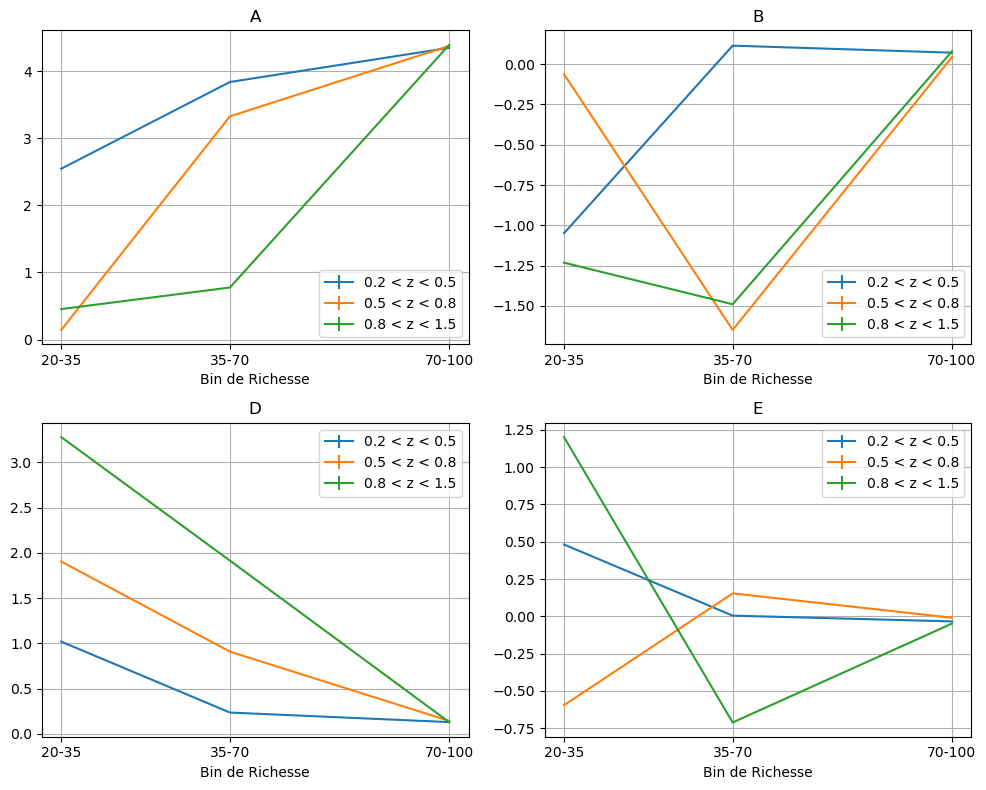

In [351]:
afficher_MCMC_binned(mat_dict_MCMC)

In [352]:
#Affiche les paramètres de plusieurs MCMC binnés
def afficher_MCMC_binned(mat_dict_MCMC):
    n_bin_redshift, n_bin_richesse = len(mat_dict_MCMC), len(mat_dict_MCMC[0])
    mat_a = np.zeros((n_bin_redshift, n_bin_richesse))
    mat_b = np.zeros((n_bin_redshift, n_bin_richesse))
    mat_c = np.zeros((n_bin_redshift, n_bin_richesse))
    mat_d = np.zeros((n_bin_redshift, n_bin_richesse))
    
    mat_A = np.zeros((n_bin_redshift, n_bin_richesse))
    mat_B = np.zeros((n_bin_redshift, n_bin_richesse))
    mat_D = np.zeros((n_bin_redshift, n_bin_richesse))
    mat_E = np.zeros((n_bin_redshift, n_bin_richesse))
    
    mat_std_A = np.zeros((n_bin_redshift, n_bin_richesse))
    mat_std_B = np.zeros((n_bin_redshift, n_bin_richesse))
    mat_std_D = np.zeros((n_bin_redshift, n_bin_richesse))
    mat_std_E = np.zeros((n_bin_redshift, n_bin_richesse))

    # if redshift dependance is taken into account
    if len(mat_dict_MCMC[0][0]['mean']) == 6:
        mat_C = np.zeros((n_bin_redshift, n_bin_richesse))
        mat_F = np.zeros((n_bin_redshift, n_bin_richesse))
        mat_std_F = np.zeros((n_bin_redshift, n_bin_richesse))
        mat_std_C = np.zeros((n_bin_redshift, n_bin_richesse))
        
    for z_bin in range(n_bin_richesse):
        for l_bin in range(n_bin_richesse):
            # Récupération des bornes des bins
            mat_a[z_bin][l_bin], mat_b[z_bin][l_bin], mat_c[z_bin][l_bin], mat_d[z_bin][l_bin] = mat_dict_MCMC[z_bin][l_bin]['bins']
            if len(mat_dict_MCMC[0][0]['mean']) == 6:
                # Récupération des valeurs moyennes des paramètres
                mat_A[z_bin][l_bin], mat_B[z_bin][l_bin], mat_C[z_bin][l_bin], mat_D[z_bin][l_bin], mat_E[z_bin][l_bin], mat_F[z_bin][l_bin] = mat_dict_MCMC[z_bin][l_bin]['mean']
                # Récupération des écarts types sur les paramètres
                mat_std_A[z_bin][l_bin], mat_std_B[z_bin][l_bin], mat_std_C[z_bin][l_bin], mat_std_D[z_bin][l_bin], mat_std_E[z_bin][l_bin], mat_std_F[z_bin][l_bin] =  mat_dict_MCMC[z_bin][l_bin]['std']
            else:
                # Récupération des valeurs moyennes des paramètres
                mat_A[z_bin][l_bin], mat_B[z_bin][l_bin], mat_D[z_bin][l_bin], mat_E[z_bin][l_bin]= mat_dict_MCMC[z_bin][l_bin]['mean']
                # Récupération des écarts types sur les paramètres
                mat_std_A[z_bin][l_bin], mat_std_B[z_bin][l_bin], mat_std_D[z_bin][l_bin], mat_std_E[z_bin][l_bin] =  mat_dict_MCMC[z_bin][l_bin]['std']
                
    # création des listes de bins de richesse et de redshift
    list_bin_richesse = [(mat_a[0][i], mat_b[0][i]) for i in range(n_bin_richesse)]
    list_bin_redshift = [(mat_c[i][0], mat_d[i][0]) for i in range(n_bin_richesse)]
    
    # création des listes des centres des bins de richesse
    bin_centers_richesse = [0.5*(list_bin_richesse[i][0]+list_bin_richesse[i][1]) for i in range(n_bin_richesse)]
    bin_labels_richesse = [str(int(list_bin_richesse[i][0]))+'-'+str(int(list_bin_richesse[i][1])) for i in range(n_bin_richesse)]
    
    # création des listes des centres des bins de redshift
    bin_centers_redshift = [0.5*(list_bin_redshift[i][0]+list_bin_redshift[i][1]) for i in range(n_bin_redshift)]
    bin_labels_redshift = [str(int(list_bin_redshift[i][0]))+'-'+str(int(list_bin_redshift[i][1])) for i in range(n_bin_redshift)]

    
    # if redshift dependance is taken into account
    if len(mat_dict_MCMC[0][0]['mean']) == 6:
        fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex=False, sharey=False)
        # plot C et F
        for i in range(n_bin_richesse):
            ax[0, 2].errorbar(bin_centers_redshift, mat_C[:,i], yerr = mat_std_C[:,i], label = str(round(list_bin_richesse[i][0], 1))+r" < $\lambda$ < "+str(round(list_bin_richesse[i][1], 1)))
            ax[1, 2].errorbar(bin_centers_redshift, mat_F[:,i], yerr = mat_std_F[:,i], label = str(round(list_bin_richesse[i][0], 1))+r" < $\lambda$ < "+str(round(list_bin_richesse[i][1], 1)))
        ax[0, 2].set_title('C')
        ax[0, 2].set_xlabel('Bin de Redshift')
        ax[0, 2].legend()
        ax[0, 2].grid()
        ax[0, 2].set_xticks(bin_centers_z)
        ax[0, 2].set_xticklabels(bin_labels_z)
        ax[1, 2].set_title('F')
        ax[1, 2].set_xlabel('Bin de Redshift')
        ax[1, 2].legend()
        ax[1, 2].grid()
        ax[1, 2].set_xticks(bin_centers_z)
        ax[1, 2].set_xticklabels(bin_labels_z)
    else:
        fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=False)

    # plot A, B, D et F
    for i in range(n_bin_redshift):
        ax[0, 0].errorbar(bin_centers_richesse, mat_A[i], yerr = mat_std_A[i], label = str(round(list_bin_redshift[i][0], 1))+" < z < "+str(round(list_bin_redshift[i][1], 1)))
        ax[0, 1].errorbar(bin_centers_richesse, mat_B[i], yerr = mat_std_B[i], label = str(round(list_bin_redshift[i][0], 1))+" < z < "+str(round(list_bin_redshift[i][1], 1)))
        ax[1, 0].errorbar(bin_centers_richesse, mat_D[i], yerr = mat_std_D[i], label = str(round(list_bin_redshift[i][0], 1))+" < z < "+str(round(list_bin_redshift[i][1], 1)))
        ax[1, 1].errorbar(bin_centers_richesse, mat_E[i], yerr = mat_std_E[i], label = str(round(list_bin_redshift[i][0], 1))+" < z < "+str(round(list_bin_redshift[i][1], 1)))
        
    ax[0, 0].set_title('A')
    ax[0, 0].set_xlabel('Bin de Richesse')
    ax[0, 0].legend()
    ax[0, 0].grid()
    ax[0, 0].set_xticks(bin_centers_richesse)
    ax[0, 0].set_xticklabels(bin_labels_richesse)

    ax[0, 1].set_title('B')
    ax[0, 1].set_xlabel('Bin de Richesse')
    ax[0, 1].legend()
    ax[0, 1].grid()
    ax[0, 1].set_xticks(bin_centers_richesse)
    ax[0, 1].set_xticklabels(bin_labels_richesse)

    ax[1, 0].set_title('D')
    ax[1, 0].set_xlabel('Bin de Richesse')
    ax[1, 0].legend()
    ax[1, 0].grid()
    ax[1, 0].set_xticks(bin_centers_richesse)
    ax[1, 0].set_xticklabels(bin_labels_richesse)

    ax[1, 1].set_title('E')
    ax[1, 1].set_xlabel('Bin de Richesse')
    ax[1, 1].legend()
    ax[1, 1].grid()
    ax[1, 1].set_xticks(bin_centers_richesse)
    ax[1, 1].set_xticklabels(bin_labels_richesse)

    plt.tight_layout()
    plt.show()

In [319]:
# Affiche la courbe de convergence pour les paramètres d'un MCMC
def afficher_convergence_mcmc(dict_MCMC, new = True):
    plt.clf()
    if len(dict_MCMC['mean']) == 4:
        list_A, list_B, list_D, list_E = dict_MCMC['list']
        if new:
            fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=False)
        N = len(A)
        ax[0, 0].set_title('A')
        ax[0, 0].plot(np.arange(0, N, 1), list_A)
        ax[0, 0].grid()
    
        ax[0, 1].set_title('B')
        ax[0, 1].plot(np.arange(0, N, 1), list_B)
        ax[0, 1].grid()
    
        ax[1,0].set_title('D')
        ax[1,0].plot(np.arange(0, N, 1), list_D)
        ax[1,0].grid()
    
        ax[1,1].set_title('E')
        ax[1,1].plot(np.arange(0, N, 1), list_E)
        ax[1,1].grid()
    else:
        list_A, list_B, list_C, list_D, list_E, list_F = dict_MCMC['list']
        if new:
            fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)
        N = len(list_A)
        ax[0, 0].set_title('A')
        ax[0, 0].plot(np.arange(0, N, 1), list_A)
        ax[0, 0].grid()
        
        ax[0, 1].set_title('B')
        ax[0, 1].plot(np.arange(0, N, 1), list_B)
        ax[0, 1].grid()
        
        ax[0, 2].set_title('C')
        ax[0, 2].plot(np.arange(0, N, 1), list_C)
        ax[0, 2].grid()
        
        ax[1,0].set_title('D')
        ax[1,0].plot(np.arange(0, N, 1), list_D)
        ax[1,0].grid()
        
        ax[1,1].set_title('E')
        ax[1,1].plot(np.arange(0, N, 1), list_E)
        ax[1,1].grid()
        
        ax[1,2].set_title('F')
        ax[1,2].plot(np.arange(0, N, 1), list_F)
        ax[1,2].grid()

In [268]:
mcmc_dict = MCMC(richesse_bin = (70, 100), redshift_bin = (0.2, 0.5), itt = 3000)

In [335]:
list_dict_mcmc = []
list_params = []
for _ in range(10):
    print(_)
    list_dict_mcmc.append(MCMC(richesse_bin =(35, 70), redshift_bin = (0.8, 1.5), itt = 3000, redshift_params = True))
    list_params.append(list_dict_mcmc[-1]['mean'])

0
1
2
3
4
5
6
7
8
9


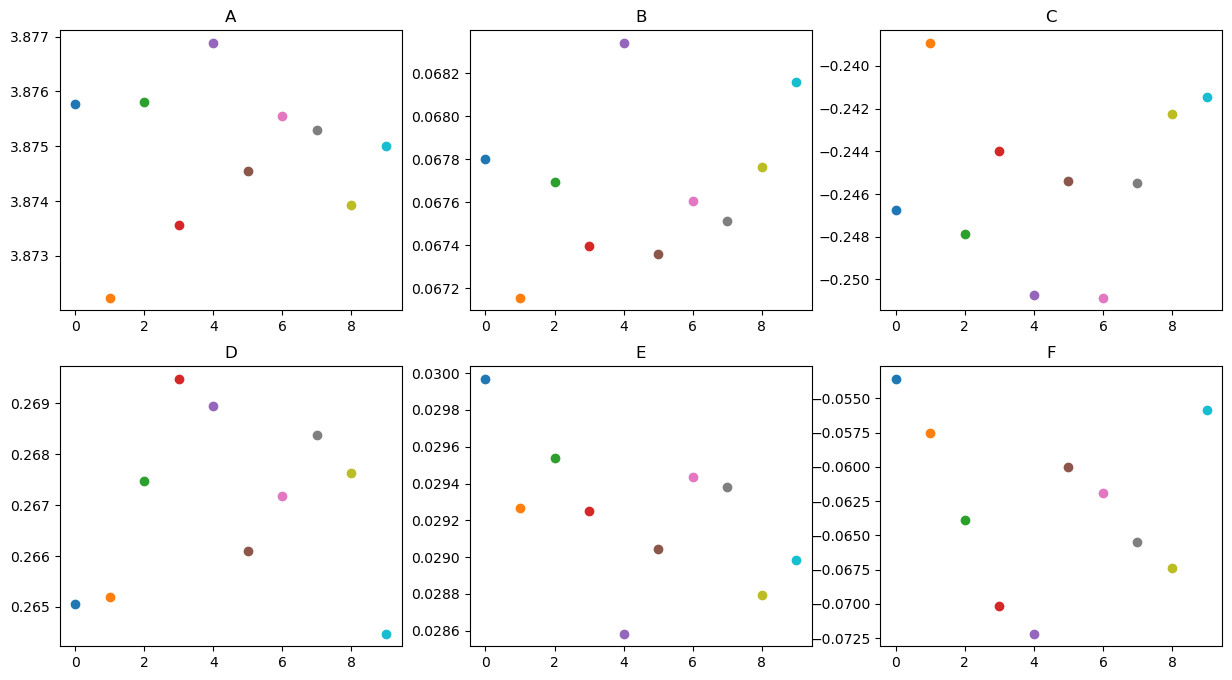

In [336]:
#afficher_convergence_mcmc(mcmc_dict2)

j = 0
fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)
for i in range(len(list_params)):
    ax[0, 0].scatter([i], [list_params[i][0]])
    ax[0, 0].set_title('A')
    ax[0, 0].grid()
    
    ax[0, 1].scatter([i], [list_params[i][1]])
    ax[0, 1].set_title('B')
    ax[0, 1].grid()
    
    ax[0, 2].scatter([i], [list_params[i][2]])
    ax[0, 2].set_title('C')
    ax[0, 2].grid()
    
    ax[1, 0].scatter([i], [list_params[i][3]])
    ax[1, 0].set_title('D')
    ax[1, 0].grid()
    
    ax[1, 1].scatter([i], [list_params[i][4]])
    ax[1, 1].set_title('E')
    ax[1, 1].grid()
    
    ax[1, 2].scatter([i], [list_params[i][5]])
    ax[1, 2].set_title('F')
    ax[1, 2].grid()
    

958


<Figure size 640x480 with 0 Axes>

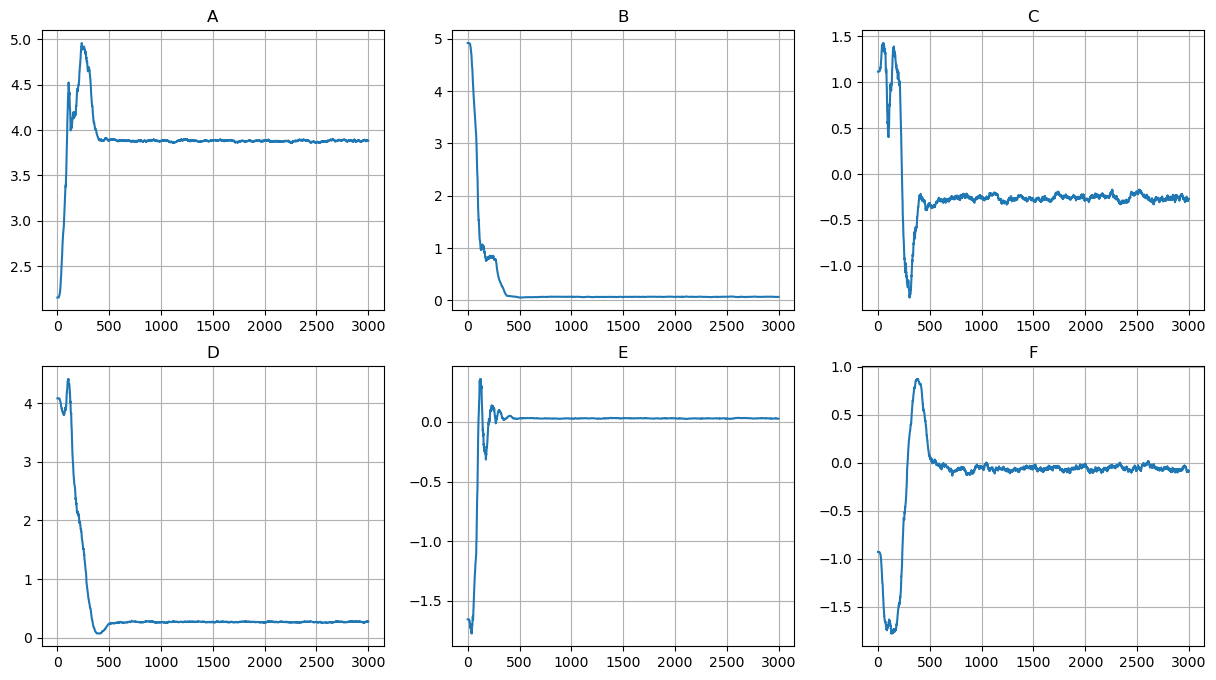

In [317]:
COUNT = 0
mcmc_dict = MCMC(richesse_bin =(35, 70), redshift_bin = (0.8, 1.5), itt = 3000, redshift_params = True)
print(COUNT)
afficher_convergence_mcmc(mcmc_dict)


In [271]:
mcmc_dict['mean']

(np.float64(4.1986162803952185),
 np.float64(0.04165735638881755),
 np.float64(0.2793997185769316),
 np.float64(0.022595601250270117),
 np.float64(-0.0773527157047114),
 np.float64(-0.442624086177783))